In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
import time
import gc
from itertools import product
import functions as func
import pyomo.environ as pyo

import pickle
from datetime import datetime

In [42]:
exponents = [0,1,2]
runs = 3

prefix = datetime.today().strftime('%y_%m_%d_')
#log_filepath = "performance_eval/" + "performance_log_"+prefix+"simulation_long_term_periods.csv"
log_filepath = "performance_eval/" + "performance_log_"+prefix+"20_80_simulation_long_term_periods.csv"
start_time = time.time_ns()
last_step_time = time.time_ns()
last_step_time = func.write_performance_log(log_filepath, 0, 0, 'Start', start_time, last_step_time, 0, '', True, True)

fix_order_costs = 9.0
margin = 0.5
cost_per_prom = 1.0
history = ["cust_nrs", "t1_buy", "t2_buy", "t3_buy", "t1_prom", "t2_prom", "t3_prom", "t1_size", "t2_size", "t3_size"]
cust_behaviour_loaded = pd.read_csv("model_eval/cust_behaviour.csv")
cust_behaviour = cust_behaviour_loaded.drop(["Unnamed: 0"], axis=1)
cust_behaviour

factors =  [210, 220, 230, 240, 250]
#factors = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
for factor in factors:
    cust_count = 1000 * factor
    min_proms = 200 * factor
    max_proms = 800 * factor
    first_cust_nr = 1000000
    orders_pre = func.create_cust_with_initial_behaviour(cust_count, first_cust_nr)
    for period in range(0, 3):
        orders_pre = func.simulate_period(orders_pre, cust_behaviour, fix_order_costs, margin, cost_per_prom, int(cust_count/2) , int(cust_count/2), period, "random")
    cust = orders_pre[history]

    for run in range(0, runs):
        orders_lp = cust.copy()
        last_step_time = func.write_performance_log(log_filepath, run+1, max_proms, 'LP_PERFORMANCE', start_time, last_step_time, cust_count, 'PREPARATION', True, False)
        orders_lp = orders_lp[history].merge(cust_behaviour, how='left', on=["t1_buy", "t2_buy", "t3_buy", "t1_prom", "t2_prom", "t3_prom"], suffixes=('_x', ''))
        orders_lp = func.calc_true_expected_profit_for_opt_strategy(orders_lp, fix_order_costs, margin, cost_per_prom) 
        last_step_time = func.write_performance_log(log_filepath, run+1, max_proms, 'LP_PERFORMANCE', start_time, last_step_time, cust_count, 'FEATURE_EXTRACTION', True, False)
        orders_lp = func.decide_prom_with_lp(orders_lp, max_proms, min_proms)
        last_step_time = func.write_performance_log(log_filepath, run+1, max_proms, 'LP_PERFORMANCE', start_time, last_step_time, cust_count, 'LP', True, False)
        orders_lp = func.generate_orders(orders_lp, margin, fix_order_costs, cost_per_prom)  
        last_step_time = func.write_performance_log(log_filepath, run+1, max_proms, 'LP_PERFORMANCE', start_time, last_step_time, cust_count, 'ORDER_GENERATION', True, False)
        

--- run 0, promotions 0, Start, , 0, 0 ---
--- run 1, promotions 168000, LP_PERFORMANCE, PREPARATION, 80841, 80840 ---
--- run 1, promotions 168000, LP_PERFORMANCE, FEATURE_EXTRACTION, 80911, 69 ---
--- run 1, promotions 168000, LP_PERFORMANCE, LP, 393799, 312888 ---
--- run 1, promotions 168000, LP_PERFORMANCE, ORDER_GENERATION, 422263, 28462 ---
--- run 2, promotions 168000, LP_PERFORMANCE, PREPARATION, 422273, 10 ---
--- run 2, promotions 168000, LP_PERFORMANCE, FEATURE_EXTRACTION, 422344, 69 ---
--- run 2, promotions 168000, LP_PERFORMANCE, LP, 774022, 351676 ---
--- run 2, promotions 168000, LP_PERFORMANCE, ORDER_GENERATION, 804779, 30756 ---
--- run 3, promotions 168000, LP_PERFORMANCE, PREPARATION, 804788, 9 ---
--- run 3, promotions 168000, LP_PERFORMANCE, FEATURE_EXTRACTION, 804846, 57 ---
--- run 3, promotions 168000, LP_PERFORMANCE, LP, 1149708, 344861 ---
--- run 3, promotions 168000, LP_PERFORMANCE, ORDER_GENERATION, 1178764, 29055 ---
--- run 1, promotions 176000, LP_PERF

In [16]:
prefix = "23_02_18_"
#log_filepath = "performance_eval/" + "performance_log_"+prefix+"simulation_long_term_periods.csv"
log_filepath = "performance_eval/" + "performance_log_"+prefix+"20_80_simulation_long_term_periods.csv"

df_perf = pd.read_csv(log_filepath, sep=';', decimal=',')
df_perf = df_perf.rename(columns={"period" : "cust_count"})

df_perf = df_perf[(df_perf["time_ms"] != "time_ms") & (df_perf["time_ms"] != 0)]
df_perf = df_perf.drop(["time_ms", "run", "policy", "proms"], axis=1)
df_perf["step_ms"] = df_perf["step_ms"].astype(int)
df_perf["step_ms"] = df_perf["step_ms"] / 1000
df_perf["cust_count"] = df_perf["cust_count"].astype(int)

df_perf.loc[df_perf["step"].isin(['FEATURE_EXTRACTION', 'ORDER_GENERATION', 'PREPARATION']) , "step"] = "weitere Simulationsschritte"
df_perf.loc[df_perf["step"] == "LP" , "step"] = "lineares Programm"
eval_perf = df_perf.groupby(["step", "cust_count"]).mean().reset_index()


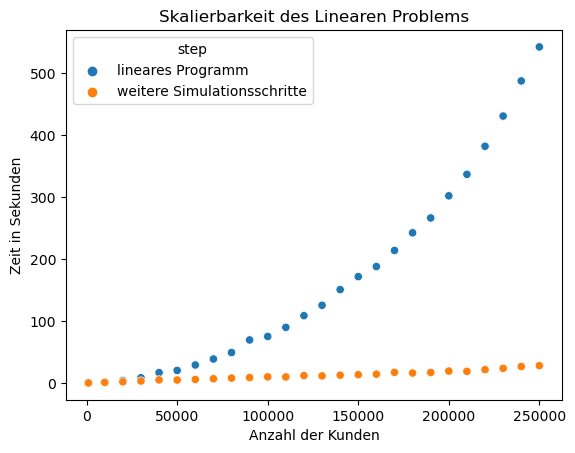

In [13]:
sns_plot = sns.scatterplot(data=eval_perf, x="cust_count", y="step_ms", hue="step")
sns_plot.set_title("Skalierbarkeit des Linearen Problems")
sns_plot.set_xlabel("Anzahl der Kunden")
sns_plot.set_ylabel("Zeit in Sekunden")
sns_plot.get_figure().savefig("performance_eval/" + prefix + "skalierbarkeit_lineares_programm.png", format="png", dpi=300)